# Movie Sentiment Analysis with Keras

In [1]:
# MLP for the IMDB problem
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence
from matplotlib import pyplot
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Using TensorFlow backend.


In [2]:
# load the dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = numpy.concatenate((X_train, X_test), axis=0)
y = numpy.concatenate((y_train, y_test), axis=0)

In [3]:
# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

Training data: 
(50000,)
(50000,)


In [4]:
# Summarize number of classes
print("Classes: ")
print(numpy.unique(y))

Classes: 
[0 1]


In [5]:
# Summarize number of words
print("Number of words: ")
print(len(numpy.unique(numpy.hstack(X))))

Number of words: 
88585


Review length: 
Mean 234.76 words (172.911495)


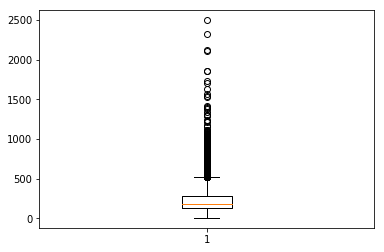

In [6]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (numpy.mean(result), numpy.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

### Word Embeddings
Word Embedding is a technique where words are encoded as real-valued vectors in a high-dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.
Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding layer.

To simplify what follows the IMDB dataset is reloaded, but only the top 5,000 words will be loaded.
The dataset is into training and test based a 50%/50% split, but it is probably more usual to use an 80/20 split.

In [7]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

Bound reviews at 500 words, truncating longer reviews and zero-padding shorter reviews.

In [8]:
# max_words = 500
# X_train = sequence.pad_sequences(X_train, maxlen=max_words)
# X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [21]:
import argparse
import numpy as np

from dan.custom_layers import AverageWords, WordDropout
from dan.preprocess import PreProcessor

from keras.layers import Embedding, Dense, Input, BatchNormalization, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adagrad, Adam
from keras import backend as K

embedding_dim = 300
num_hidden_layers = 3
num_hidden_units = 300
num_epochs = 100
batch_size = 100
dropout_rate = 0.2
word_dropout_rate = 0.3
activation = 'relu'

args = {}
args['data']='data/out_split.pk'
args['We']='data/glove.6B.300d.txt'
args['model']='nbow'
args['wd']='y'

reviews=X_train
reviews_val=X_test
labels=y_train
labels_val=y_test



pp = PreProcessor(reviews,reviews_val,args['We'])
pp.tokenize()

# data, labels, data_val, labels_val = pp.make_data()

embedding_matrix = pp.get_word_embedding_matrix(embedding_dim)

model = Sequential()

args = []
if args['We'] == "rand":
    model.add(Embedding(len(pp.word_index) + 1,embedding_dim,input_length=pp.MAX_SEQUENCE_LENGTH,trainable=False))
else:
    model.add(Embedding(len(pp.word_index)+1,embedding_dim,weights=[embedding_matrix],input_length=pp.MAX_SEQUENCE_LENGTH,trainable=False))

if args['wd'] == 'y':
    model.add(WordDropout(word_dropout_rate))
model.add(AverageWords())

if args['model'] == 'dan':
    for i in range(num_hidden_layers):
        model.add(Dense(num_hidden_units))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout_rate))

model.add(Dense(labels.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('softmax'))

adam = Adam()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['categorical_accuracy'])

model.summary()

# get_embedding_layer_output = K.function([model.layers[0].input],[model.layers[0].output])
# el_output = np.mean(get_embedding_layer_output([data])[0],axis=1)
# print el_output

# get_average_word_layer_output = K.function([model.layers[0].input],[model.layers[1].output])
# print get_average_word_layer_output([data])[0]

model.fit(data,labels,batch_size=batch_size,epochs=num_epochs,validation_data=(data_val,labels_val))

# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)



NameError: name 'reviews' is not defined